In [117]:
red = '#982462'
blue = '#3C5FDA'

In [91]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 1

from fc_utils.from_node_to_network import conv_to_network, check_symmetric
from nilearn.plotting import plot_connectome, view_connectome, view_markers
from scipy.io import loadmat, matlab
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matlab.engine
import scipy
from fc_utils.get_edge_vals import get_edge_vals
from fc_utils.get_permutation_p_value import get_permutation_p_value
from fc_utils.load_mat import load_mat_modified, symmetrize

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import os
from random import shuffle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
def get_intersection_graph(cpm_edges,  propofol_filename,  which='pos'):
    propofol_mat = get_conmat(propofol_filename)
    
    # only keep intersection
    intersect = propofol_mat * cpm_edges
    
    # turn 0s back to nans so they don't show up in plot
    intersect[intersect==0] = np.nan

    p = create_plot_from_adj(adj_mat=intersect,  which=which)
    return p

In [106]:
def get_intersection_with_pval(cpm_edges, 
                               file_name=f'./thresh_3_1/rest/rest_high_network_thresh_3_1_sig_05.mat'):
    # grab rest conmat
    prop_mat = get_conmat(file_name)
    # turn the nans to 0's
    prop_mat = np.nan_to_num(prop_mat)
    # make conmat list of ones and zeros instead of t-stats
    prop_mat = prop_mat.astype(bool).astype(int)
    
    # turn the symmetric matrices to a flat list of vals
    prop_flat  = get_edge_vals(prop_mat)
    cpm_flat = get_edge_vals(cpm_edges)
    
    intersect = prop_flat.astype(bool) & cpm_flat.astype(bool)
    
    
    
    intersect = intersect.astype(float)
    intersect_sum = intersect.sum()
    intersect_percent = intersect_sum / np.nansum(cpm_flat)

    # calculate null
    random_intersections = []
    for i in range(1000):
        np.random.shuffle(prop_flat)
        rand_intersect = prop_flat.astype(bool) & cpm_flat.astype(bool)
        rand_intersect = rand_intersect.astype(float)
        random_intersections.append(rand_intersect.sum()/ np.nansum(cpm_flat))
        
    p_val = get_permutation_p_value([intersect_percent], random_intersections)

    # getting a random network of size of cpm net
    # return the sum of intersect, the total number of edges in cpm net, and the p-val of intersection
    return intersect_sum, np.nansum(cpm_flat), p_val, random_intersections

In [94]:
# todo - only need one of these in utils!
def load_greene_networks():
    # this function loads the greene networks,
    # and turns the 259 x 259 matrix into a 268 x 268 matrix
    # by placing rows of nans where there are missing nodes

    # load greene net original 
    greeneCPM_load = sio.loadmat('/Users/taylorchamberlain/code/fc_ts_utils/fc_utils/network_definitions/gFnets_p01_hcp.mat')
    gf_posedges = greeneCPM_load['task_pos_edge'][7,:,:]
    gf_negedges = greeneCPM_load['task_neg_edge'][7,:,:]

    nodes_missing_in_green = [108, 114, 117, 128, 238, 242, 248, 249, 265]

    # convert greene into 268 x 268
    missing_so_far_i, missing_so_far_j = 0, 0
    greene_268_pos = np.full([268, 268], np.nan)
    greene_268_neg = np.full([268, 268], np.nan)

    for i in range(268):
        if i in nodes_missing_in_green:
            missing_so_far_i += 1
        missing_so_far_j = 0
        for j in range(268):
            if j in nodes_missing_in_green:
                missing_so_far_j+=1
            if i not in nodes_missing_in_green and j not in nodes_missing_in_green:
                greene_268_pos[i, j] = gf_posedges[i-missing_so_far_i, j-missing_so_far_j]
                greene_268_neg[i, j] = gf_negedges[i-missing_so_far_i, j-missing_so_far_j]


    greene_268_pos = np.nan_to_num(greene_268_pos)
    greene_268_neg = np.nan_to_num(greene_268_neg)
    return greene_268_pos, greene_268_neg

In [2]:
def normalize(matrix):
    return (matrix - np.nanmean(matrix)) / np.nanstd(matrix)

In [118]:
def get_conmat(file):
    loaded = load_mat_modified(file)
    test_stat = loaded['nbs']['NBS']['test_stat']

    e = loaded['nbs']['NBS']['con_mat']
    e = e.toarray()
    adjacency = symmetrize(e)
    
    test = test_stat.copy()
    test[~adjacency.astype(bool)]=np.nan
    return test


def get_test_stat(file):
    loaded = load_mat_modified(file)
    test_stat = loaded['nbs']['NBS']['test_stat']

    return test_stat


def get_cmap(which='pos'):
    norm = matplotlib.colors.Normalize(-1,1)

    if which== 'neg':
        colors = [[norm(-1.0), blue], [norm(1.0), blue]]
    else:
        colors = [[norm(-1.0), red], [norm(1.0), red]] 

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    return cmap

In [29]:
def create_plot_from_adj(adj_mat=None, which='pos'):
    conmat = adj_mat
    
    # you grab the nodes to keep
    keep = []
    for i in range(268):
        for j in range(268):
            if not np.isnan(conmat[i,j]) and conmat[i,j]!=0:
                keep.append(i)
                keep.append(j)

    keep  = list(set(keep))

    # exclude edges that are not in the network 
    conmat = conmat[keep, :]
    conmat = conmat[:, keep]
    node_color = [(.5, .5, .5) for i in range(len(keep))]

    if 'pos' ==which:
        cmap = get_cmap(which='pos')
    else:
        cmap = get_cmap(which='neg')

    # get list of shen nodes that were keeping, that are in the network
    shen268_labels = pd.read_csv('/Users/taylorchamberlain/code/fc_ts_utils/fc_utils/network_definitions/xilin_268parc_labels.csv')    
    shen268_labels.drop(columns=['IGNORE'], inplace=True)
    shen268_labels = shen268_labels.reset_index()
    final_nodes = shen268_labels[shen268_labels['index'].isin(keep)]

    return view_connectome(normalize(conmat), 
                           final_nodes[['MNI_X', 'MNI_Y', 'MNI_Z']], 
                           node_size=6,
                            colorbar_fontsize=20,
                            symmetric_cmap=True,
                            edge_cmap=cmap,
                            node_color=node_color,  
                            linewidth=11)


In [120]:
def create_plot(nbs_output_file_name=None):
    conmat = get_conmat(nbs_output_file_name)

    # you grab the nodes to keep
    keep = []
    for i in range(268):
        for j in range(268):
            if not np.isnan(conmat[i,j]) and conmat[i,j]!=0:
                keep.append(i)
                keep.append(j)

    keep  = list(set(keep))

    # exclude edges that are not in the network 
    conmat = conmat[keep, :]
    conmat = conmat[:, keep]

    # get list of shen nodes that were keeping, that are in the network
    shen268_labels = pd.read_csv('/Users/taylorchamberlain/code/fc_ts_utils/fc_utils/network_definitions/xilin_268parc_labels.csv')
    shen268_labels.drop(columns=['IGNORE'], inplace=True)
    shen268_labels = shen268_labels.reset_index()
    final_nodes = shen268_labels[shen268_labels['index'].isin(keep)]

    node_color = [(.5, .5, .5) for i in range(len(keep))]
    
    if 'pos' in nbs_output_file_name:
        cmap = get_cmap(which='pos')
    else:
        cmap = get_cmap(which='neg')

    view = view_connectome(normalize(conmat), 
                           final_nodes[['MNI_X', 'MNI_Y', 'MNI_Z']], 
                           node_size=6,
                            colorbar_fontsize=20,
                            symmetric_cmap=False,
                            edge_cmap=cmap,
                            node_color=node_color,  
                            linewidth=11)
    return view

# Create Figure 3 -> Glass brain plots of propofol networks + overlap

### _Fig3_  - plot  `propofol` network (p<.001)

In [131]:
# POSITIVE
p  = create_plot(nbs_output_file_name = './nbs_files/rest_pos_001_sig_05.mat')
p.save_as_html('../figures/Figure3/pos_propofol_001.html')


# NEGATIVE
p = create_plot(nbs_output_file_name = './nbs_files/rest_neg_001_sig_05.mat')
p.save_as_html('../figures/Figure3/neg_propofol_001.html')


### _Fig3_  - plot `propofol`-`saCPM` overlap ( p<.01 )

In [132]:
# load sust attn net
saCPM_posedges = np.loadtxt('/Users/taylorchamberlain/code/fc_ts_utils/fc_utils/network_definitions/sa_cpm/sa_cpm_pos_mask.txt')
saCPM_negedges = np.loadtxt('/Users/taylorchamberlain/code/fc_ts_utils/fc_utils/network_definitions/sa_cpm/sa_cpm_neg_mask.txt')

In [133]:
# POSITIVE
p = get_intersection_graph(saCPM_posedges, './nbs_files/rest_pos_01_sig_05.mat')
p.save_as_html('../figures/Figure3/OVERLAP_pos_saCPM_propofol_01.html')


In [134]:
# NEGATIVE
p = get_intersection_graph(saCPM_negedges, './nbs_files/rest_neg_01_sig_05.mat', which='neg')
p.save_as_html('../figures/Figure3/OVERLAP_neg_saCPM_propofol_01.html')


###  _Fig3_  - `propofol`-`gfCPM` overlap ( p<.01 )

In [135]:
# load fluid intelligence net
gfCPM_posedges = load_greene_networks()[0]
gfCPM_negedges = load_greene_networks()[1]

In [136]:
# POSITIVE
p = get_intersection_graph(gfCPM_posedges, './nbs_files/rest_pos_01_sig_05.mat')
p.save_as_html('../figures/Figure3/OVERLAP_pos_gfCPM_propofol_01.html')


In [137]:
# NEGATIVE
p = get_intersection_graph(gfCPM_negedges, './nbs_files/rest_neg_01_sig_05.mat', which='neg')
p.save_as_html('../figures/Figure3/OVERLAP_neg_gfCPM_propofol_01.html')


# Create Figure 4 -> Bar graph of overlap

## calculate intersection at every p-value for all networks

In [107]:
def create_intersection_dataframe(saCPM_posedges, saCPM_negedges, gfCPM_posedges, gfCPM_negedges):
    networks_names = ['sustained\nattention', 'fluid\nintelligence']
    tasks = ['movie', 'rest']
    thresh_levels = ['05', '01', '001']

    networks = {
        'sustained\nattention':(saCPM_posedges, saCPM_negedges), 
        'fluid\nintelligence': (gfCPM_posedges, gfCPM_negedges), 
    }
    data = {
        'net':[],
        'thresh':[],
        'which_nbs_which_cpm':[],
        'task':[],
        'intersect_percent':[], 
        'p_val':[],
        'which_nbs':[],
        'which_cpm':[],
        'random_intersect': [],
    }
    for net in networks_names:
        posedges, negedges = networks[net]
        for task in tasks:
            for thresh in thresh_levels:
                for which_nbs in ['pos', 'neg']:
                    nbs_file = f'./nbs_files/{task}_{which_nbs}_{thresh}_sig_05.mat'
                    if os.path.exists(nbs_file):
                        for which_net in ['pos', 'neg']:
                            edges = posedges
                            if which_net =='neg':
                                edges = negedges
                            intersect, possible_edges, p, random_intersect = get_intersection_with_pval(edges, 
                                                                                              file_name=nbs_file)
                            data['net'].append(net)
                            data['thresh'].append(thresh)
                            data['which_nbs_which_cpm'].append(which_nbs + '_' + which_net)
                            data['which_nbs'].append(which_nbs)
                            data['which_cpm'].append(which_net)

                            data['task'].append(task)
                            data['random_intersect'].append(random_intersect)

                            data['p_val'].append(p)
                            data['intersect_percent'].append(intersect/possible_edges)


    df = pd.DataFrame(data)
    return df

In [113]:
def make_bar_plots(df, which='pos'):
    sns.despine()
    sns.set(font_scale=1.5, style="white")

    plt.rc("axes.spines", top=False, right=False)
    fig, axes = plt.subplots(2,3,figsize=(10,10), sharey=True)
    flat_ax = axes.flatten()
    tasks = ['rest', 'movie']
    thresh_levels  = ['05','01','001']
    index = 0
    fig.subplots_adjust(wspace=1)
    for task_i, task in enumerate(tasks):

        for which_i, which in enumerate([which]):

            for thresh_i, thresh in enumerate(thresh_levels):
                ax  =flat_ax[index]
                t = df[df['which_nbs']==which]
                t  = t[t['thresh']==thresh]
                t  = t[t['task']==task]

                if t.shape[0]>0:

                    g = sns.barplot(data=t,
                                    ci=None,
                                    x='which_cpm', 
                                    hue='net', 
                                    y='intersect_percent',
                                    ax=ax)
                    g.get_legend().remove()

                if task=='movie':
                    ax.set_xlabel( 'p < .'+ str(thresh), size=28)
                else:
                    ax.set_xlabel( '')
                ax.set_ylabel('')
                ax.set_xticks([])
                ax.set_ylim([0, .20])

                if index==0 or index==3:
                    ax.set_ylabel(task,  size=28)

                index+=1
                
                
                for i, bar in enumerate(ax.patches):                    
                    if i ==1:
                        bar.set_color('#33cccc')
                        bar.set_edgecolor('white')

                    elif i ==3:
                        bar.set_color('#33cccc')
                        bar.set_hatch('++')
                        bar.set_edgecolor('white')
                    elif i==0:
                        bar.set_color('#ffa31a')
                    elif i==2:
                        bar.set_color('#ffa31a')
                        bar.set_hatch('++')
                        bar.set_edgecolor('white')
                    plt.tight_layout()


    return fig
                        




In [108]:
df = create_intersection_dataframe(saCPM_posedges, 
                                   saCPM_negedges, 
                                   gfCPM_posedges, 
                                   gfCPM_negedges)

<Figure size 432x288 with 0 Axes>

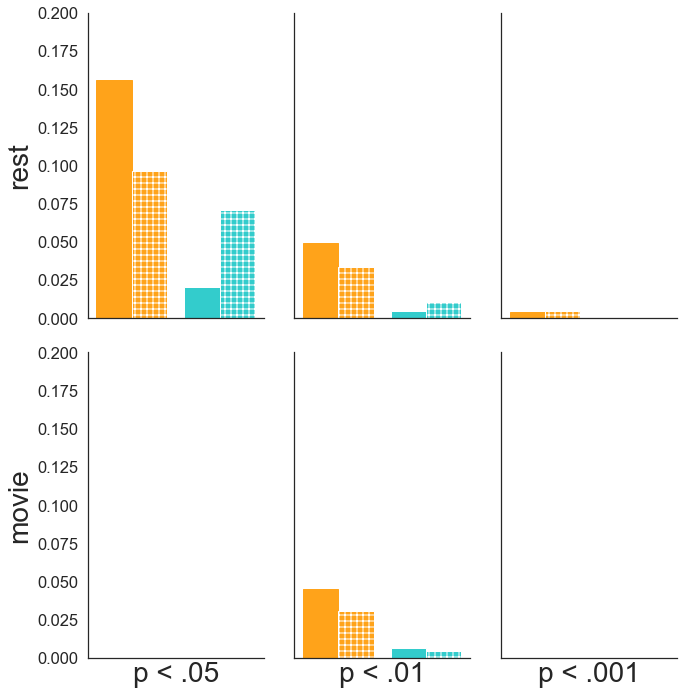

In [114]:
pos_bargraph = make_bar_plots(df, which='pos')
# save to figures
pos_bargraph.savefig('../figures/Figure4/pos_bargraph.png')

<Figure size 432x288 with 0 Axes>

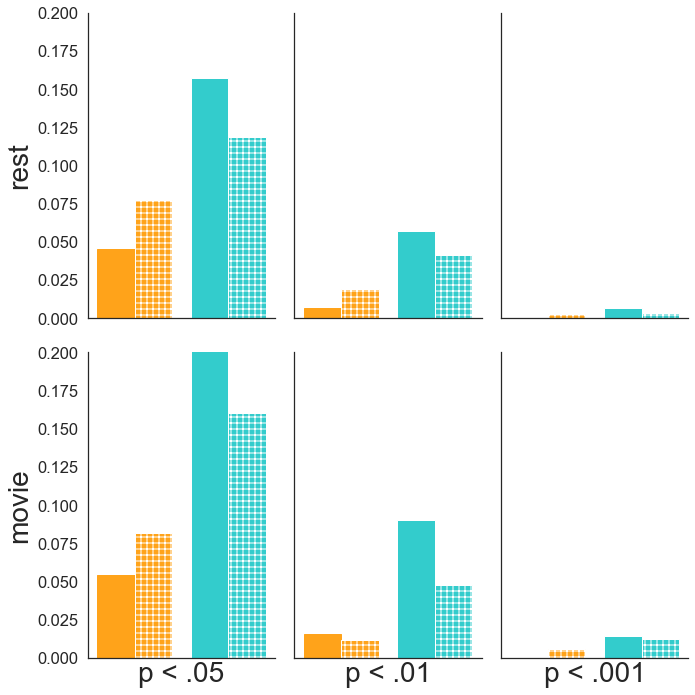

In [115]:
neg_bargraph = make_bar_plots(df, which='neg')
# save to figures
neg_bargraph.savefig('../figures/Figure4/neg_bargraph.png')